In [ ]:
import string
import nltk
import torch
from torch import nn
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.nn.functional as F
import copy
from model import Model

In [2]:
try:
    with open('../../datasets/Shakespeare_sonnets/sonnets.txt', 'r') as iofile:
        text = iofile.readlines()
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt -nc
    with open('sonnets.txt', 'r') as iofile:
        text = iofile.readlines()

Файл «sonnets.txt» уже существует — не загружается.



In [4]:
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
text = [x.lower() for x in text]

text_tokens = []
for line in text:
    text_tokens += nltk.word_tokenize(line) 
    text_tokens += ["\n"] 


In [8]:
unique_tokens = np.unique(np.array(text_tokens))
tokenised_text = [np.where(unique_tokens == x)[0] for x in text_tokens]

In [10]:
inp = tokenised_text[:-1]
target = copy.deepcopy(tokenised_text)[1:]

In [11]:
LSTM_SIZE = 128
EMBEDDING_DIM = 128
NUM_LAYERS = 3
BATCH_SIZE = 256
LR = 0.01
N_EPOCHS = 100
MAX_LENGTH = 100
DICT_SIZE = len(unique_tokens)

In [12]:
model = Model(DICT_SIZE, LSTM_SIZE, EMBEDDING_DIM, NUM_LAYERS)
opt = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [13]:
def train(model, optimizer, inp, target, criterion, BATCH_SIZE, N_EPOCHS, DICT_SIZE):
    history = []
    
    model.train()
    
    size_for_batch = int(len(inp) / BATCH_SIZE) - 1
    
    for epoch in range(N_EPOCHS):
        
        history.append(0)
    
        for i in range(size_for_batch):
        
            hidden = model.init_state(BATCH_SIZE)

            batched_inp = torch.tensor(inp[i * BATCH_SIZE : (i + 1) * BATCH_SIZE], dtype=torch.long)
            batched_trg = torch.tensor(target[i * BATCH_SIZE : (i + 1) * BATCH_SIZE], dtype=torch.long)

            optimizer.zero_grad()

            output, _ = model(batched_inp, hidden)

            loss = criterion(output.contiguous().view(-1, DICT_SIZE),
                             batched_trg.contiguous().view(-1))
            
            history[epoch] += loss
            
            loss.backward()
            optimizer.step()
        
        history[epoch] /= size_for_batch
        
        if (epoch) % 10 == 0:
            clear_output(True)
            plt.plot(history,label='loss')
            plt.legend()
            plt.show()
        
    return history

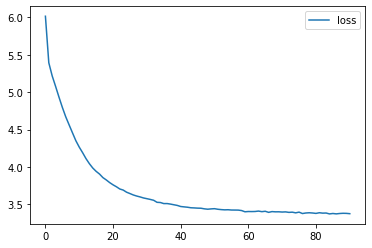

In [14]:
history = train(model, opt, inp, target, criterion, BATCH_SIZE, N_EPOCHS, DICT_SIZE)

In [15]:
def generate_sample(model, phrase, unique_tokens, max_length=MAX_LENGTH, temperature=1.0):

    phrase = phrase.lower()
    
    with torch.no_grad(): 
        phrase_text = nltk.word_tokenize(phrase)
        tokenised_text = [np.where(unique_tokens == x)[0] for x in phrase_text]
        x_sequence = [torch.tensor([tokenised_text[i]], dtype=torch.long) for i in range(len(tokenised_text))]
        
        hid_state = model.init_state(1)
      
        for i in range(len(tokenised_text)):
            out, hid_state = model(x_sequence[i], hid_state)


        for _ in range(max_length - len(tokenised_text)):
            
            out, hid_state = model(x_sequence[-1], hid_state)
            
            p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0] 
  

            next_ix = np.random.choice(len(unique_tokens), p=p_next.squeeze(0))
        
            next_ix = torch.tensor([next_ix], dtype=torch.long).unsqueeze(0)
            x_sequence.append(next_ix)

        
    return ' '.join([unique_tokens[ix] for ix in x_sequence])

In [22]:
print(generate_sample(model, "I love you", unique_tokens, max_length=150, temperature=1.5))

i love you me , of love thee are thou the no goest flesh , years not nothing are , speaking as i so as he , thou before to the praise ; my age to so woe ; 
 and to set all thy great us , 
 
 lxxiv 
 is rud'st they my thoughts have drain 'd can , can have my . love excuse me than but by no blot his least upon thee , 
 to me so your self mine is , to my true others with the times his for hand confounds in , my best , his love no sick doth to more bred , in for i should all his cold love . 
 and 
 if that my lines more in praise far . 
 without from thy heart kind-hearted thy worth are rich old tyrant thy , my all


In [24]:
print(generate_sample(model, "The sweetest woman", unique_tokens, max_length=150, temperature=1.0))

the sweetest woman 's sail of all that i never am not be 
 hath not so your truth . 
 
 
 that as that do i all my deeds , the praise they in death to no a time that do not seem my love that to dost breathe , to this thy love that by nature , whose my true soul , you and in all , my thy good of life , 
 and art of my love ; 
 so is it is his death , 
 in the 
 and the place hindmost , , i 
 it for that you is it with my most . love to your love to give me disgrace , 
 
 the can i not , then i may not say to that i hold thy beauty for the i love , in my love of that


In [27]:
print(generate_sample(model, "The world is dark", unique_tokens, max_length=50, temperature=0.8))

the world is dark days , 
 if that it is to show thee was not in this thy love strong , 
 
 
 the for nothing the praise , 
 
 of that in the true breath ? 
 to no , i have i do be .
